In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/wonminkim/Projects/DATCapstone/data2/data_nasdaq30.csv', index_col=0)
df['Date'] = pd.to_datetime(df['Date'])

# # Forward fill micro, macro, stock
# df[df.columns[1:40]] = df[df.columns[1:40]].ffill()
# # Fill 0 to sentiment
# df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)

df[df.columns[1:40]] = df.groupby('Ticker')[df.columns[1:40]].ffill()
df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)
df = df.dropna(subset=df.columns[0:-5])

In [3]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_763,emb_764,emb_765,emb_766,emb_767,Target_1day,Target_1week,Target_1month,Target_1year,Ticker
1,2021-06-30,51.020300,51.064953,50.405327,50.976429,8033000,0.0,0.0,23368.861,5.9,...,0.000000,0.000000,0.000000,0.000000,0.000000,-1.381153,-3.499493,-2.434052,-15.471237,LRCX
2,2021-06-30,262.336040,262.985346,261.279683,262.539551,21656500,0.0,0.0,23368.861,5.9,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.678436,6.318848,15.118622,-11.945267,MSFT
4,2021-07-01,50.739052,50.873019,49.450347,49.595276,11343000,0.0,0.0,23921.991,5.4,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.127697,-1.584057,0.340004,-14.998257,LRCX
5,2021-07-01,261.289382,263.450571,261.279710,263.217987,16725300,0.0,0.0,23921.991,5.4,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.863251,6.144318,12.899231,-8.930435,MSFT
7,2021-07-02,50.156197,50.236102,49.119745,49.467579,7426000,0.0,0.0,23921.991,5.4,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.747364,-0.471603,0.811611,-14.943474,LRCX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24360,2025-01-31,91.530824,94.147412,91.021485,91.121353,20540200,0.0,0.0,29723.864,4.0,...,0.016103,-0.779442,-1.247877,-0.557506,0.750644,NaN,NaN,NaN,NaN,MU
24362,2025-01-31,123.768618,127.838243,119.179044,120.058960,390372900,0.0,0.0,29723.864,4.0,...,0.961005,-0.782348,-0.184249,-0.365352,0.674119,NaN,NaN,NaN,NaN,NVDA
24364,2025-01-31,149.438733,150.360590,148.953037,149.369354,4906700,0.0,0.0,29723.864,4.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,PEP
24366,2025-01-31,171.584803,175.841847,171.365981,172.002548,7809000,0.0,0.0,29723.864,4.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,QCOM


In [4]:
# 정렬
df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

# lag 생성 대상 컬럼과 시차
lag_cols = df.columns[1:40]
lags = [1, 3, 7]

# lag feature를 저장할 리스트
lag_features = []

# lag된 컬럼들 생성
for col in lag_cols:
    for lag in lags:
        lagged = df.groupby('Ticker')[col].shift(lag)
        lag_features.append(lagged.rename(f'{col}_lag{lag}'))

# lag된 컬럼들 DataFrame으로 병합
lag_df = pd.concat(lag_features, axis=1)

# 원본 df와 합치기
df = pd.concat([df.reset_index(drop=True), lag_df.reset_index(drop=True)], axis=1)

# 필요 시 결측치 제거
df = df.dropna().reset_index(drop=True)

In [5]:
from sklearn.decomposition import PCA

# 1. PCA 적용
pca = PCA(n_components=0.95, random_state=42)
emb_cols = [col for col in df.columns if col.startswith("emb_")]
X_emb = df[emb_cols]
X_emb_pca = pca.fit_transform(X_emb)

# 2. PCA 결과를 emb_pca_ 접두사 붙여서 DataFrame으로 변환
pca_columns = [f"emb_pca_{i}" for i in range(X_emb_pca.shape[1])]
df_pca_part = pd.DataFrame(X_emb_pca, columns=pca_columns, index=df.index)

# 3. 원래 데이터에서 emb_ 컬럼 제거
df_non_pca = df.drop(columns=emb_cols)

# 4. 두 DataFrame 합치기
df_pca = pd.concat([df_non_pca.reset_index(drop=True), df_pca_part.reset_index(drop=True)], axis=1)

# 결과 확인
df_pca.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_pca_48,emb_pca_49,emb_pca_50,emb_pca_51,emb_pca_52,emb_pca_53,emb_pca_54,emb_pca_55,emb_pca_56,emb_pca_57
0,2021-10-11,139.619603,142.112277,139.168166,140.149536,64452200,0.0,0.0,24777.038,4.5,...,-0.00092,-0.001324,0.000679,-0.000412,-0.000477,0.0001,-0.000164,-0.000478,0.000174,0.000036
1,2021-10-12,140.561677,140.581308,138.412473,138.873718,73035900,0.0,0.0,24777.038,4.5,...,-0.00092,-0.001324,0.000679,-0.000412,-0.000477,0.0001,-0.000164,-0.000478,0.000174,0.000036
2,2021-10-13,138.608797,138.765805,136.606792,138.284943,78762700,0.0,0.0,24777.038,4.5,...,-0.00092,-0.001324,0.000679,-0.000412,-0.000477,0.0001,-0.000164,-0.000478,0.000174,0.000036
3,2021-10-14,139.462562,141.199592,138.873734,141.081818,69907100,0.0,0.0,24777.038,4.5,...,-0.00092,-0.001324,0.000679,-0.000412,-0.000477,0.0001,-0.000164,-0.000478,0.000174,0.000036
4,2021-10-15,141.091650,142.200588,140.836484,142.141708,67940300,0.0,0.0,24777.038,4.5,...,-0.00092,-0.001324,0.000679,-0.000412,-0.000477,0.0001,-0.000164,-0.000478,0.000174,0.000036


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def random_forest(data, target):
    df = data.copy()
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)

    # Drop other Targets and NaNs
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # Date processing
    df['Date'] = pd.to_datetime(df['Date'])

    # One-hot encode Ticker
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y 분리
    y = df[target]
    X = df.drop(columns=['Date', target])

    # 정규화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # 하이퍼파라미터 그리드 설정
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }

    # GridSearchCV 설정
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                               param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               verbose=1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # 예측
    y_pred = best_model.predict(X_test)

    # 평가
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # 시각화
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 10, 'n_estimators': 200}

 Evaluation:
Mean Squared Error (MSE): 4.5555
Mean Absolute Error (MAE): 1.4132
R² Score: 0.0072


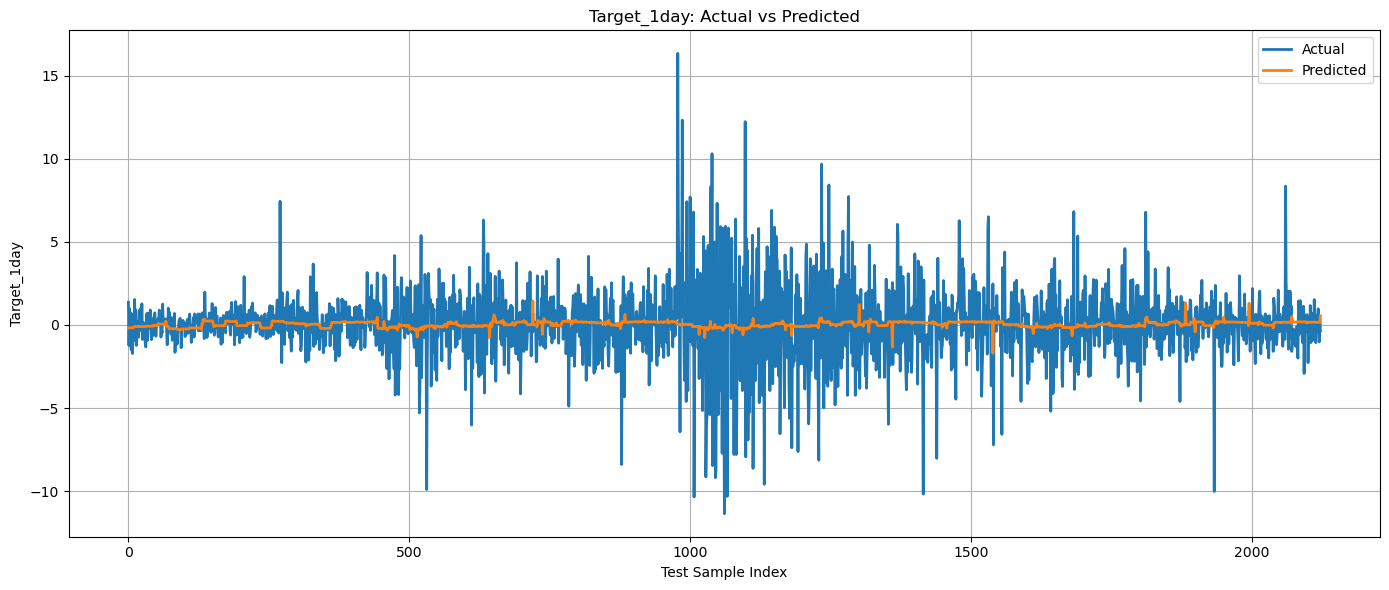

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 10, 'n_estimators': 200}

 Evaluation:
Mean Squared Error (MSE): 19.6300
Mean Absolute Error (MAE): 3.1947
R² Score: 0.0618


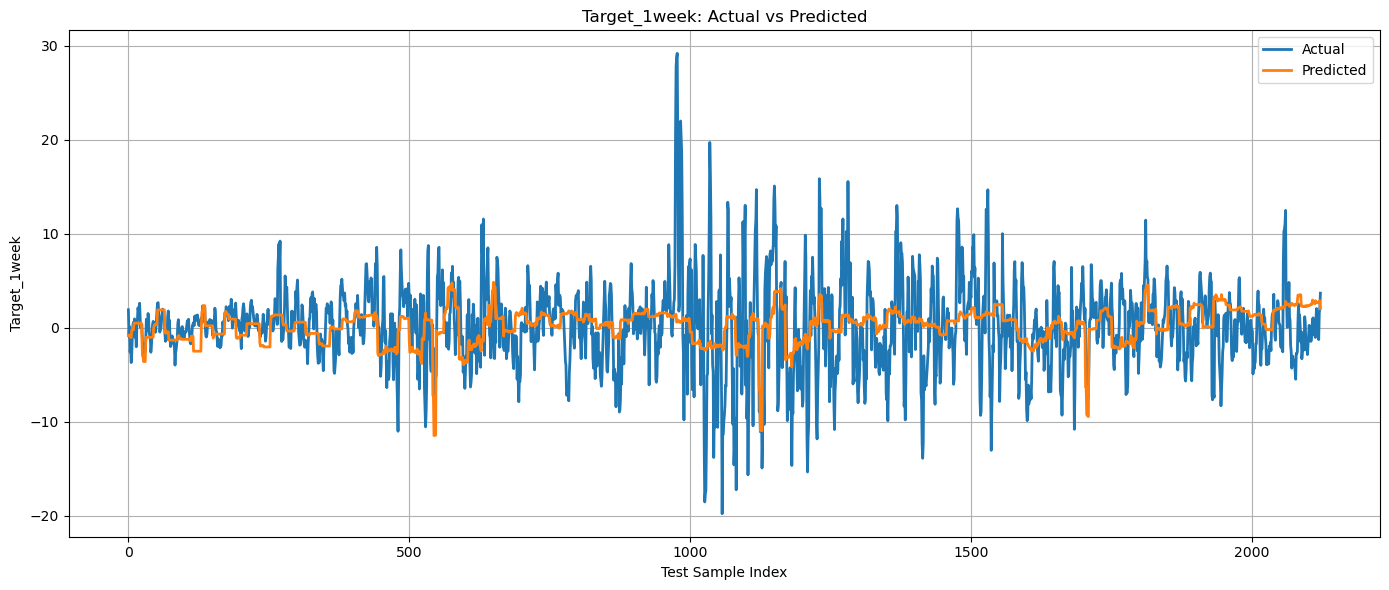

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 10, 'n_estimators': 100}

 Evaluation:
Mean Squared Error (MSE): 67.5048
Mean Absolute Error (MAE): 5.8618
R² Score: 0.1467


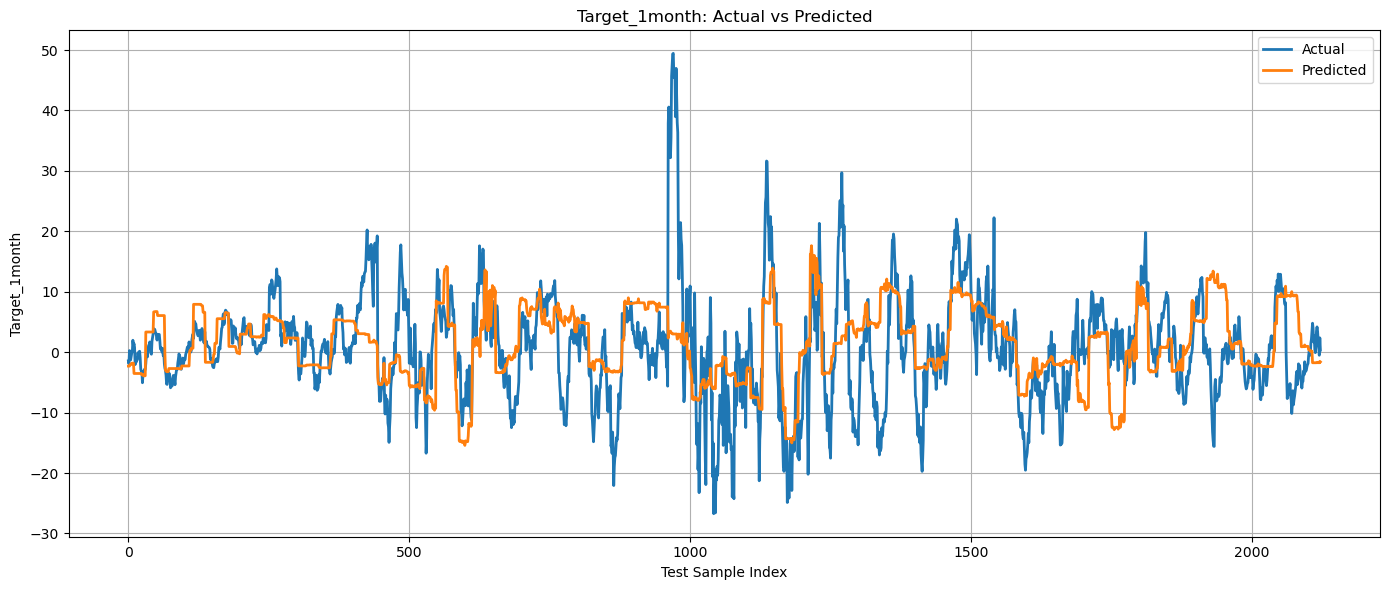

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': None, 'n_estimators': 200}

 Evaluation:
Mean Squared Error (MSE): 1178.5582
Mean Absolute Error (MAE): 26.1261
R² Score: -0.0236


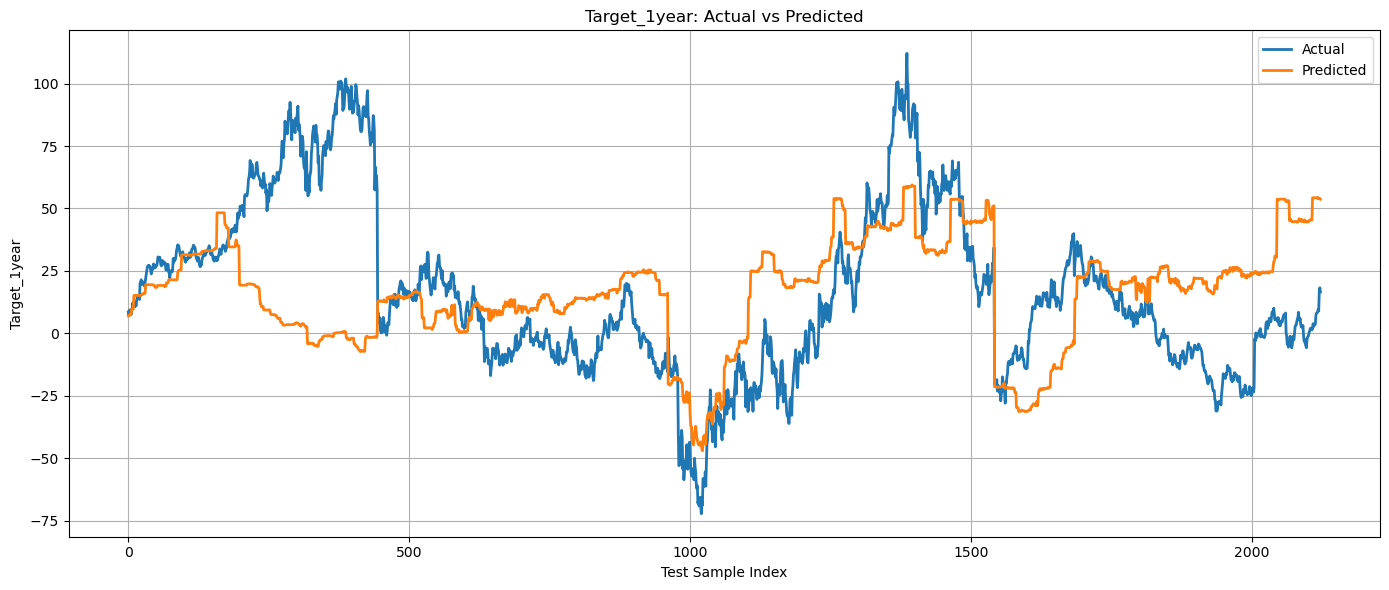

In [7]:
random_forest(df_pca, 'Target_1day')
random_forest(df_pca, 'Target_1week')
random_forest(df_pca, 'Target_1month')
random_forest(df_pca, 'Target_1year')

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

def lightgbm_model(data, target):
    df = data.copy()
    
    # 1. 타겟 처리
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # 2. 날짜 처리
    df['Date'] = pd.to_datetime(df['Date'])

    # 3. 범주형 처리
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # 4. X, y 분리
    y = df[target]
    X = df.drop(columns=['Date', target])

    # 5. 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 6. 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # 7. 하이퍼파라미터 그리드
    param_grid = {
        'num_leaves': [31, 63],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200]
    }

    # 8. GridSearchCV
    model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               verbose=0,
                               n_jobs=-1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # 9. 예측
    y_pred = best_model.predict(X_test)

    # 10. 평가
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # 11. 시각화
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted (LightGBM)')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/opt/anaconda3/envs/dat490/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24865
[LightGBM] [Info] Total Bins 24727
[LightGBM] [Info] Number of data points in the train set: 5659, number of used features: 221
[LightGBM] [Info] Number of data points in the train set: 5659, number of used features: 220
[LightGBM] [Info] Start training from score 0.070806
[LightGBM] [Info] Start training from score 0.074643
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

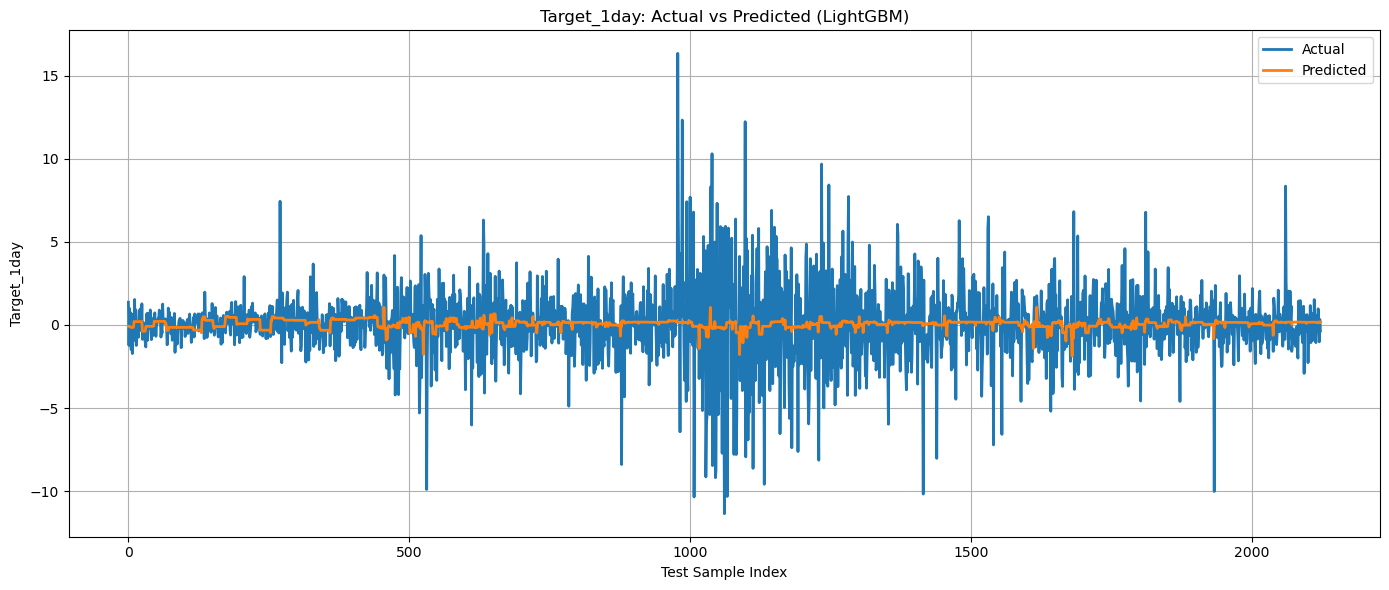

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24727
[LightGBM] [Info] Number of data points in the train set: 5659, number of used features: 220
[LightGBM] [Info] Start training from score 0.377991
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24518
[LightGBM] [Info] Number of data points in the train set: 5658, number of used features: 221
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [I

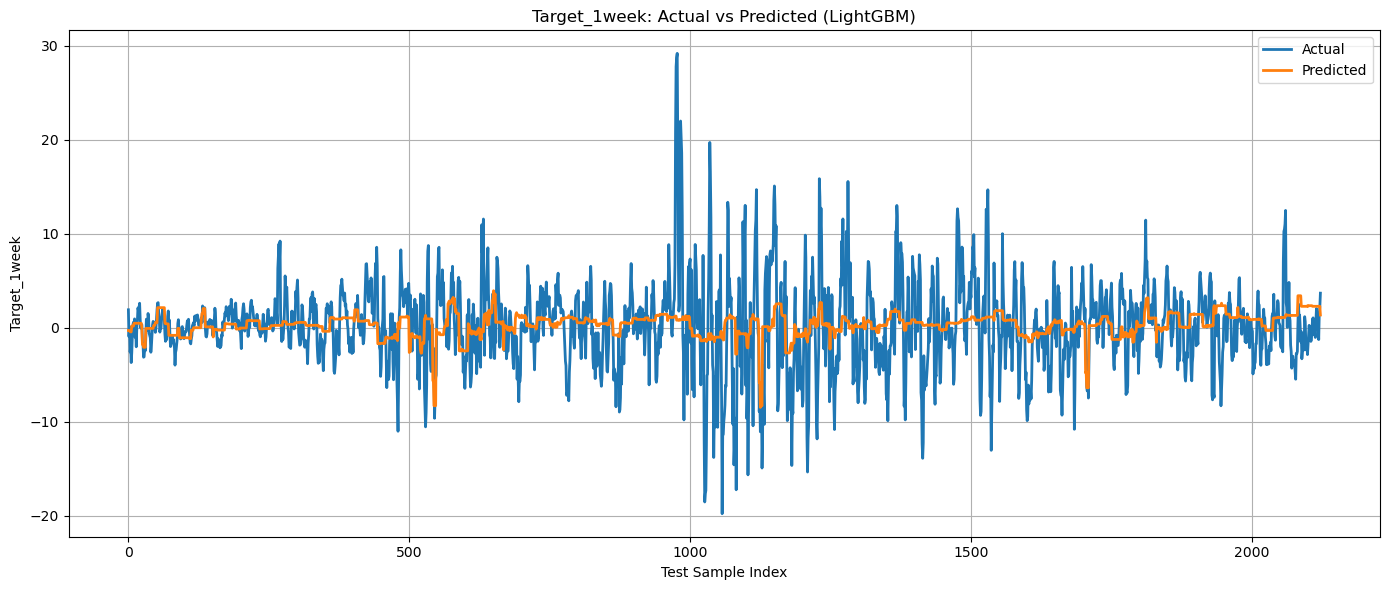

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24727
[LightGBM] [Info] Number of data points in the train set: 5659, number of used features: 220
[LightGBM] [Info] Start training from score 1.712346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24865
[LightGBM] [Info] Number of data points in the train set: 5659, number of used features: 221
[LightGBM] [Info] Start training from score 1.594971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

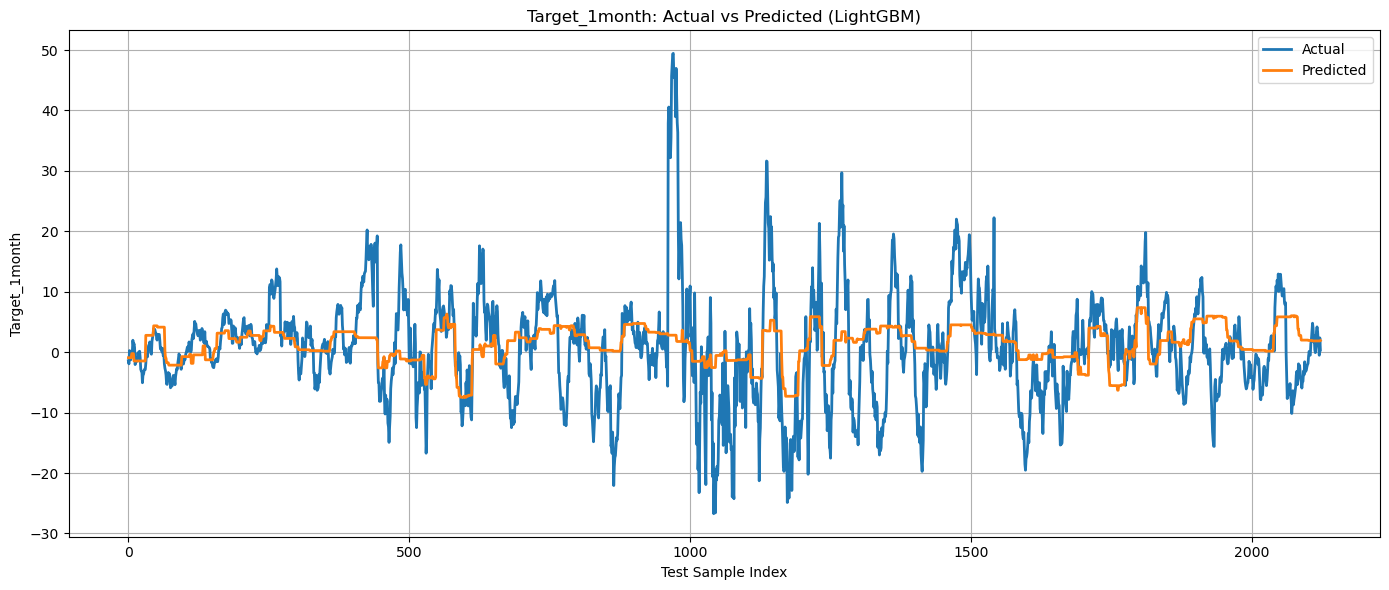

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24865
[LightGBM] [Info] Number of data points in the train set: 5659, number of used features: 221
[LightGBM] [Info] Start training from score 24.906731
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24518
[LightGBM] [Info] Total Bins 24727
[LightGBM] [Info] Number of data points in the train set: 5658, number of used features: 221
[LightGBM] [Info] Number of data points i

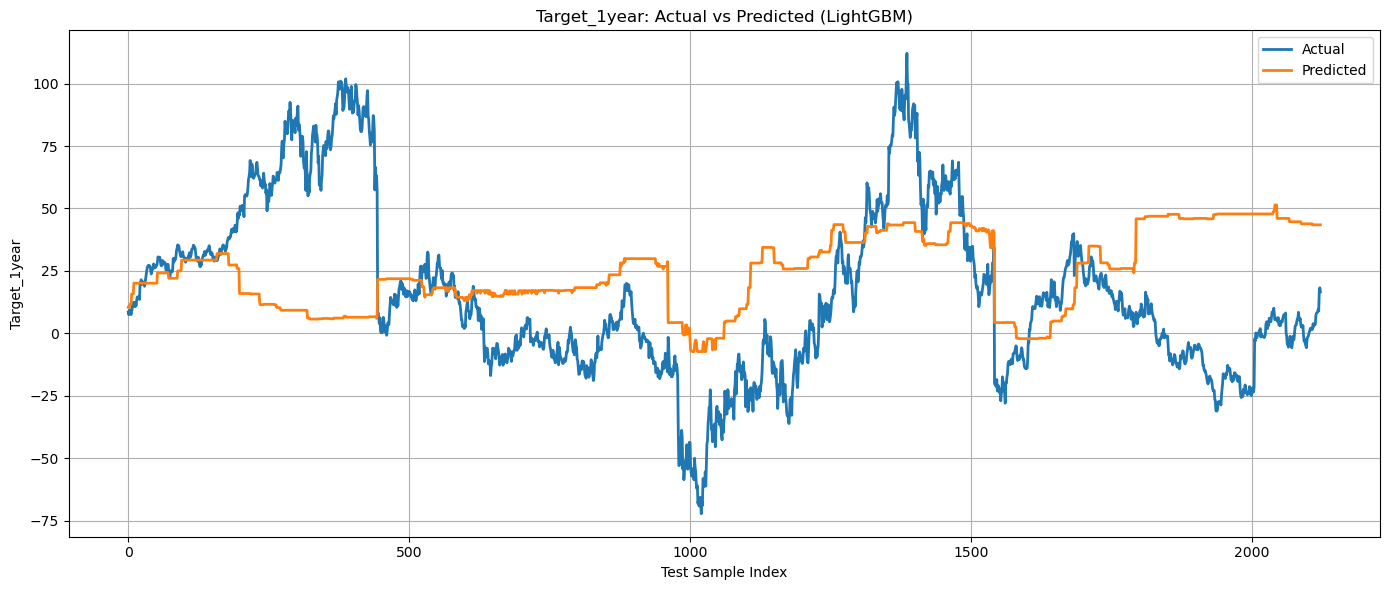

In [9]:
lightgbm_model(df_pca, 'Target_1day')
lightgbm_model(df_pca, 'Target_1week')
lightgbm_model(df_pca, 'Target_1month')
lightgbm_model(df_pca, 'Target_1year')